# About Dataset

It contains images of jaguar and a table with their labels, the images are cropped to only leave the masks and part of jaguars

# Exploration & Data loading

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import os
import io
import tqdm
import seaborn as sns
import random
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import timm

d:\Kaggle\Jaguar ReIdentification Challenge\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# labels
label_table = pd.read_csv('../data/raw/train.csv')
label_table.head()

,filename,ground_truth
0,train_0001.png,Abril
1,train_0002.png,Abril
2,train_0003.png,Abril
3,train_0004.png,Akaloi
4,train_0005.png,Akaloi


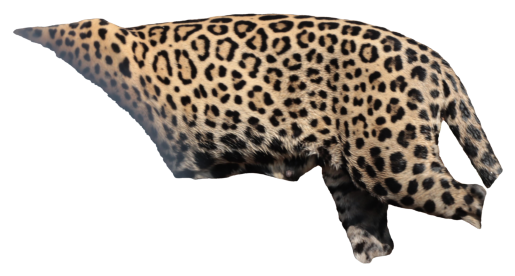

Label:  Jaju


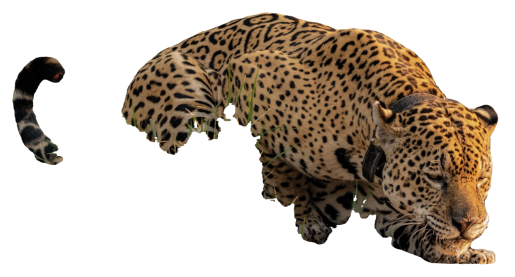

Label:  Ousado


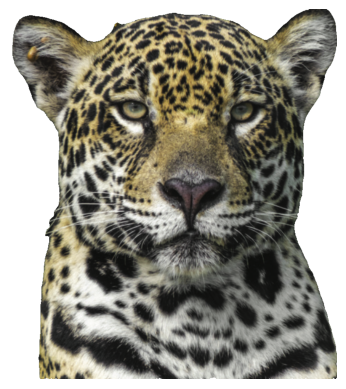

Label:  Guaraci


In [22]:
train_image_path = '../data/raw/train/train'

def show_image(image_path, label_table=None):
    '''
    Show an image given its file path.
    Args:
        image_path (str): The file path of the image to be displayed.
    '''
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    if label_table is not None:
        print("Label: ", label_table.loc[label_table['filename'] == os.path.basename(image_path), 'ground_truth'].values[0])

def show_random_images(label_table, num_images=5):
    '''
    Show random images from the training dataset and its label.
    Args:
        label_table (pd.DataFrame): The DataFrame containing image labels and paths.
        num_images (int): The number of random images to display.    
    '''
    random_indices = np.random.choice(label_table.index, size=num_images, replace=False)
    for idx in random_indices:
        image_id = label_table.loc[idx, 'filename']
        image_path = os.path.join(train_image_path, image_id)
        show_image(image_path, label_table=label_table)
        #print("Label:", label_table.loc[idx, 'ground_truth'])

show_random_images(label_table, num_images=3)

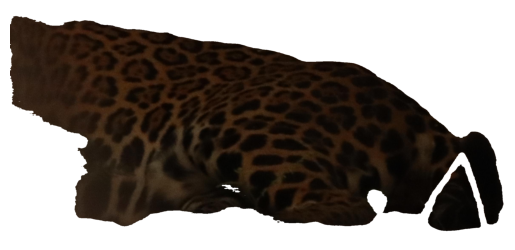

Label:  Pyte


In [23]:
show_image(os.path.join(train_image_path, 'train_0085.png'), label_table=label_table)

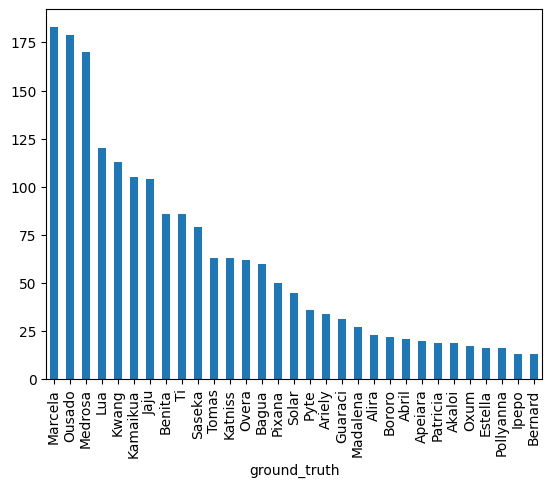

In [24]:
label_table['ground_truth'].value_counts().plot(kind='bar');

-> Class imbalance

In [25]:
# Check for corrupted images using PIL

def is_corrupted_pil(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verify it's a valid image
            img = Image.open(image_path)  # Reopen for processing
            img.load()  # Load all pixel data
            # Check if image is mostly black
            histogram = img.convert('L').histogram()
            if sum(histogram[:50]) > sum(histogram) * 0.8:
                return "Likely too dark"
        return "OK"
    except Exception as e:
        return f"Corrupted: {str(e)}"

if not os.path.exists('intermediate'):
    os.makedirs('intermediate')

if not os.path.exists('intermediate/corruption_results.csv'):
    corruption_results = []
    for idx, row in tqdm.tqdm(label_table.iterrows(), total=label_table.shape[0]):
        image_id = row['filename']
        image_path = os.path.join(train_image_path, image_id)
        result = is_corrupted_pil(image_path)
        corruption_results.append((image_id, result))

In [26]:
if not os.path.exists('intermediate/corruption_results.csv'):
    corruption_results_df = pd.DataFrame(corruption_results, columns=['filename', 'corruption_status'])
    corruption_results_df.to_csv('intermediate/corruption_results.csv', index=False)
    print(corruption_results_df.head())

if os.path.exists('intermediate/corruption_results.csv'):
    corruption_results_df = pd.read_csv('intermediate/corruption_results.csv')
    print(corruption_results_df.head())

         filename corruption_status
0  train_0001.png                OK
1  train_0002.png                OK
2  train_0003.png                OK
3  train_0004.png                OK
4  train_0005.png                OK


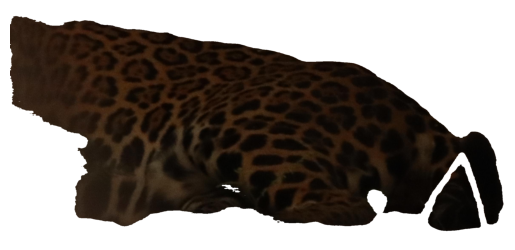

Label:  Pyte


In [27]:
show_image(os.path.join(train_image_path, 'train_0085.png'), label_table=label_table)

In [28]:
# Analyze image lighting conditions

def analyze_image_lighting(image_path):
    img = Image.open(image_path).convert('L')
    gray = np.array(img)

    brightness = np.mean(gray)
    contrast = gray.std()

    hist, _ = np.histogram(gray, bins=256, range=(0, 256))
    dark_pixels = np.sum(hist[:50]) / np.sum(hist) * 100

    return {
        'filename': os.path.basename(image_path),
        'brightness': brightness,
        'contrast': contrast,
        'dark_percentage': dark_pixels,
        'is_dark': brightness < 40 or dark_pixels > 60,
        'low_contrast': contrast < 20
    }

image_analysis = analyze_image_lighting(os.path.join(train_image_path, 'train_0085.png'))
print(image_analysis)

{'filename': 'train_0085.png', 'brightness': np.float64(26.051425122978642), 'contrast': np.float64(12.186233117582264), 'dark_percentage': np.float64(97.60625394544076), 'is_dark': np.True_, 'low_contrast': np.True_}


In [29]:
if not os.path.exists('intermediate/lighting_contrast_results.csv'):
    lighting_contrast_results = []
    for idx, row in tqdm.tqdm(label_table.iterrows(), total=label_table.shape[0]):
        image_id = row['filename']
        image_path = os.path.join(train_image_path, image_id)
        result = analyze_image_lighting(image_path)
        lighting_contrast_results.append((image_id, result))

In [30]:
if not os.path.exists('intermediate/lighting_contrast_results.csv'):
    lighting_contrast_results_df = pd.DataFrame(lighting_contrast_results, columns=['filename', 'analysis'])
    lighting_contrast_results_df = pd.json_normalize(lighting_contrast_results_df['analysis'])
    #lighting_contrast_results_df = pd.concat([lighting_contrast_results_df.drop('analysis', axis=1),  lighting_contrast_results_df], axis=1)
    lighting_contrast_results_df.to_csv('intermediate/lighting_contrast_results.csv', index=False)
    print(lighting_contrast_results_df.head())

if os.path.exists('intermediate/lighting_contrast_results.csv'):
    lighting_contrast_results_df = pd.read_csv('intermediate/lighting_contrast_results.csv')
    #lighting_contrast_results_df = pd.json_normalize(lighting_contrast_results_df['analysis'])
    #lighting_contrast_results_df = pd.concat([lighting_contrast_results_df.drop('analysis', axis=1),  lighting_contrast_results_df], axis=1)
    print(lighting_contrast_results_df.head())

         filename  brightness   contrast  dark_percentage  is_dark  \
0  train_0001.png   85.682996  40.793495        20.616807    False   
1  train_0002.png   85.288834  40.653441        21.166222    False   
2  train_0003.png   86.395097  40.802523        21.134740    False   
3  train_0004.png   99.181228  23.909947         3.622408    False   
4  train_0005.png  117.765126  39.554654         7.992894    False   

   low_contrast  
0         False  
1         False  
2         False  
3         False  
4         False  


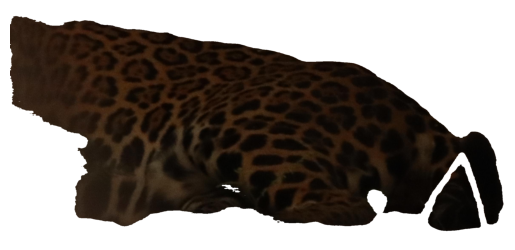

Label:  Pyte


In [31]:
show_image(os.path.join(train_image_path, 'train_0085.png'), label_table=label_table)

In [32]:
# Show image dimensions
def show_dimensions(image_path):
    img = Image.open(image_path)
    print(f"Image dimensions: {img.size}")
    
show_dimensions(os.path.join(train_image_path, 'train_0085.png'))

def show_dimensions_random_images(label_table, num_images=5):
    random_indices = np.random.choice(label_table.index, size=num_images, replace=False)
    for idx in random_indices:
        image_id = label_table.loc[idx, 'filename']
        image_path = os.path.join(train_image_path, image_id)
        show_dimensions(image_path)
    
show_dimensions_random_images(label_table, num_images=3)

Image dimensions: (2330, 1081)
Image dimensions: (3732, 3205)
Image dimensions: (6919, 3345)
Image dimensions: (1802, 397)


100%|██████████| 1895/1895 [00:00<00:00, 5736.85it/s]


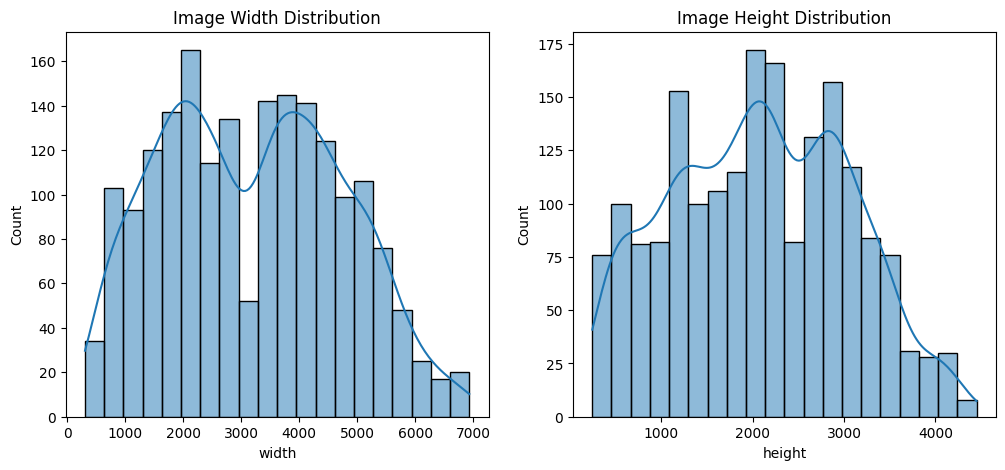

In [33]:
def show_dimensions_histogram(label_table):
    dimensions = []
    for idx, row in tqdm.tqdm(label_table.iterrows(), total=label_table.shape[0]):
        image_id = row['filename']
        image_path = os.path.join(train_image_path, image_id)
        img = Image.open(image_path)
        dimensions.append(img.size)
    
    dimensions_df = pd.DataFrame(dimensions, columns=['width', 'height'])
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(dimensions_df['width'], bins=20, kde=True)
    plt.title('Image Width Distribution')
    plt.subplot(1, 2, 2)
    sns.histplot(dimensions_df['height'], bins=20, kde=True)
    plt.title('Image Height Distribution')
    plt.show()

show_dimensions_histogram(label_table)

## Dataset creation

In [34]:
class JaguarDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
        
        if not self.is_test:
            # Map labels
            self.label_map = {name: idx for idx, name in enumerate(df['ground_truth'].unique())}
            self.df['label'] = self.df['ground_truth'].map(self.label_map)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['filename']
        img_path = os.path.join(self.img_dir, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # Robustness: If a file is missing/corrupt, return a black image instead of crashing
            # logging only once to avoid spamming
            if idx == 0: print(f"Warning: Could not load {img_path}. Returning black image. ({e})")
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
            
        if self.is_test:
            return image, img_name
        else:
            label = torch.tensor(row['label'], dtype=torch.long)
            return image, label

In [36]:
unique_ids = sorted(label_table['ground_truth'].unique())
label_map = {name: i for i, name in enumerate(unique_ids)}
NUM_CLASSES = len(unique_ids)

print(f"Number of Classes: {NUM_CLASSES}")

Number of Classes: 31


In [37]:
transform = transforms.Compose([
    transforms.Resize(224),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [38]:
train_dataset = JaguarDataset(label_table, train_image_path ,transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

## Model and architecture

In [ ]:
# 3. ARCFACE & MODEL
class ArcFaceLayer(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label=None):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        if label is None: return cosine
        phi = cosine - self.m
        one_hot = torch.zeros(cosine.size(), device=input.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

class JaguarReIDModel(nn.Module):
    def __init__(self, model_name, embedding_size, num_classes, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        in_features = self.backbone.num_features
        self.neck = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, embedding_size),
            nn.BatchNorm1d(embedding_size),
        )
        self.head = ArcFaceLayer(embedding_size, num_classes)

    def forward(self, x, label=None):
        features = self.backbone(x)
        embeddings = self.neck(features)
        if label is not None: return self.head(embeddings, label)
        return embeddings